# Flights Delayed-Linear Regression Model

In this notebook we will create a simple regression model to predict the number of flights that will be delay at the arrival to its destination.

The data set used can be found in [Kaggle](https://www.kaggle.com/datasets/sriharshaeedala/airline-delay/data).

This data is structured by carrier, airport and contains the different reason of delays.

The target feature is '***arr_delay***' which represent the total arrival delayed.
Here are the steps to create this model:

1. Data Preparation
2. Data Exploration
3. Train the Regression Model
4. Evaluate the Model
5. Next Steps

## Data Preparation



*   Handle Null Values
*   Text Columns to Category Codes



### Handle Null Values

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Deactivate warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', ConvergenceWarning)

In [28]:
# Import the data
df = pd.read_csv('Airline_Delay_Cause.csv', low_memory=True)

df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,8,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",89.0,13.0,2.25,1.60,...,0.0,5.99,2.0,1.0,1375.0,71.0,761.0,118.0,0.0,425.0
1,2023,8,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",62.0,10.0,1.97,0.04,...,0.0,7.42,0.0,1.0,799.0,218.0,1.0,62.0,0.0,518.0
2,2023,8,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,10.0,2.73,1.18,...,0.0,4.28,1.0,0.0,766.0,56.0,188.0,78.0,0.0,444.0
3,2023,8,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",66.0,12.0,3.69,2.27,...,0.0,1.57,1.0,1.0,1397.0,471.0,320.0,388.0,0.0,218.0
4,2023,8,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",92.0,22.0,7.76,0.00,...,0.0,11.28,2.0,0.0,1530.0,628.0,0.0,134.0,0.0,768.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171666 entries, 0 to 171665
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 171666 non-null  int64  
 1   month                171666 non-null  int64  
 2   carrier              171666 non-null  object 
 3   carrier_name         171666 non-null  object 
 4   airport              171666 non-null  object 
 5   airport_name         171666 non-null  object 
 6   arr_flights          171426 non-null  float64
 7   arr_del15            171223 non-null  float64
 8   carrier_ct           171426 non-null  float64
 9   weather_ct           171426 non-null  float64
 10  nas_ct               171426 non-null  float64
 11  security_ct          171426 non-null  float64
 12  late_aircraft_ct     171426 non-null  float64
 13  arr_cancelled        171426 non-null  float64
 14  arr_diverted         171426 non-null  float64
 15  arr_delay        

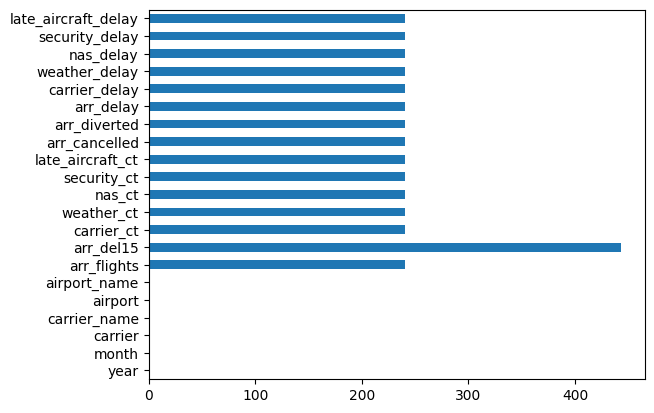

In [30]:
null_counts = df.isna().sum()

# Visualize the nulls
null_counts.plot(kind='barh')
plt.show()

In [31]:
# Since all features above are numerical, we can replace with 0
df = df.fillna(0)

### Text Columns to Category Codes

The Model we will use can only be fitted with numerical values.

In [32]:
# Save original numerical columns
numerical_cols = df.select_dtypes(include=['int', 'float']).columns
numerical_cols

Index(['year', 'month', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct',
       'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled',
       'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay',
       'nas_delay', 'security_delay', 'late_aircraft_delay'],
      dtype='object')

In [33]:
# Identify categorical columns
c = (df.dtypes == 'object')
categorical_cols = list(c[c].index)
categorical_codes = []

# Keep original columns to use in the exploration
for col in df[categorical_cols]:
  col_name = col + '_cat'
  categorical_codes.append(col_name)
  df[col + '_cat'] = df[col].astype('category').cat.codes

categorical_codes

['carrier_cat', 'carrier_name_cat', 'airport_cat', 'airport_name_cat']

In [34]:
df[categorical_codes].head()

,carrier_cat,carrier_name_cat,airport_cat,airport_name_cat
0,0,6,0,10
1,0,6,4,6
2,0,6,11,9
3,0,6,12,21
4,0,6,14,7


## Data Exploration

* Basic Stats
* Data Distribution
* Relationships: Numerical & arr_delay
* Relationships: Categorical & arr_delay
* Select Strong Relationships Columns Only

### Basic Stats

In [35]:
df[numerical_cols].describe()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000,171666.000000
mean,2018.551361,6.493633,362.021629,66.262947,20.767540,2.247201,19.354051,0.156877,23.737321,7.519969,0.862180,4233.560257,1435.175847,222.252339,919.364574,7.372403,1649.390881
std,2.890006,3.440908,992.292811,179.340557,50.285995,7.309621,61.636370,0.716927,72.348306,43.625260,3.770353,12610.737070,4213.072116,820.554483,3421.288285,41.751680,5218.591764
min,2013.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,4.000000,50.000000,6.000000,2.140000,0.000000,1.000000,0.000000,1.210000,0.000000,0.000000,333.000000,109.000000,0.000000,34.000000,0.000000,65.000000
50%,2019.000000,7.000000,100.000000,17.000000,6.380000,0.390000,3.900000,0.000000,5.000000,1.000000,0.000000,1015.000000,373.000000,18.000000,146.000000,0.000000,319.000000
75%,2021.000000,9.000000,249.000000,47.000000,17.220000,1.860000,11.680000,0.000000,15.230000,4.000000,1.000000,2879.000000,1107.000000,146.000000,476.000000,0.000000,1069.000000
max,2023.000000,12.000000,21977.000000,4176.000000,1293.910000,266.420000,1884.420000,58.690000,2069.070000,4951.000000,197.000000,438783.000000,196944.000000,31960.000000,112018.000000,3760.000000,227959.000000


### Data Distribution

Numerical Columns

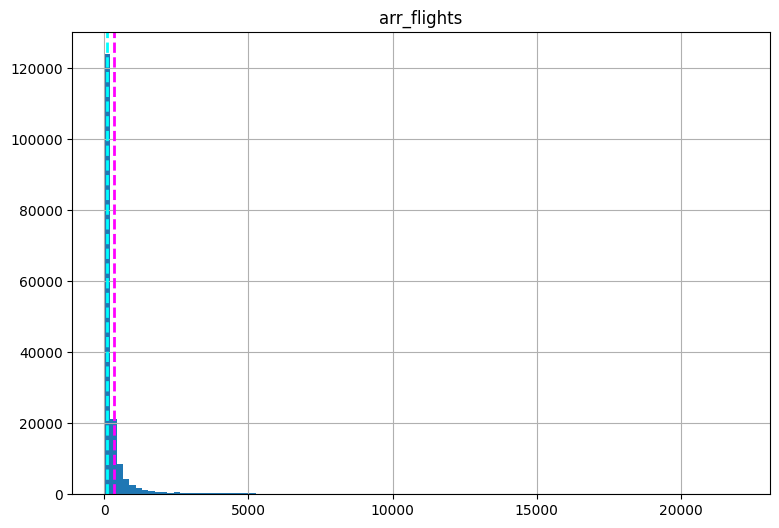

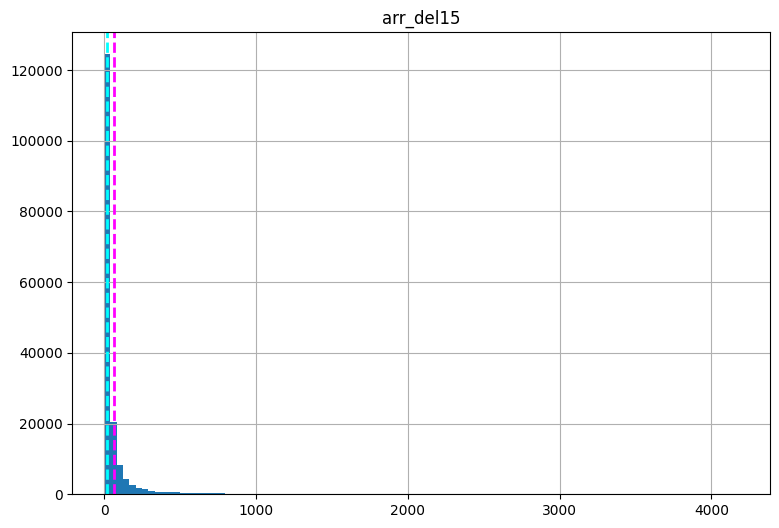

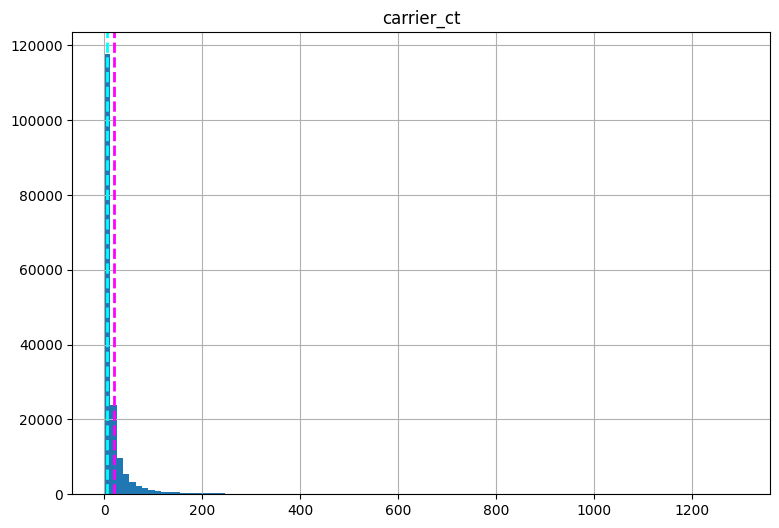

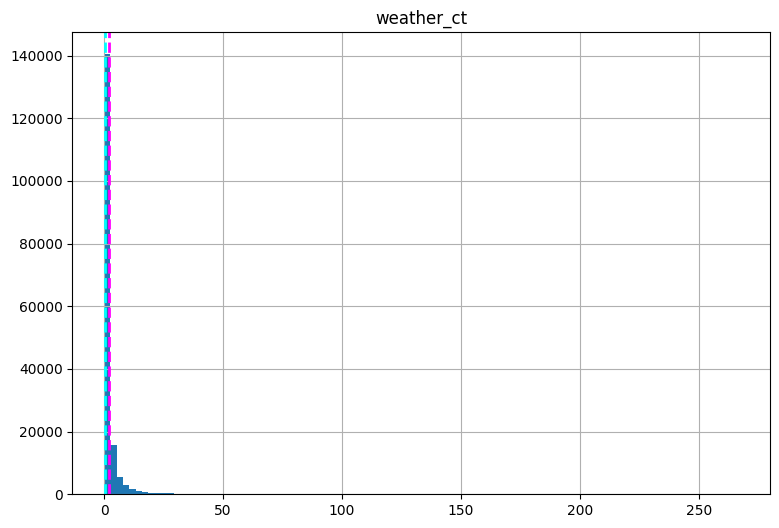

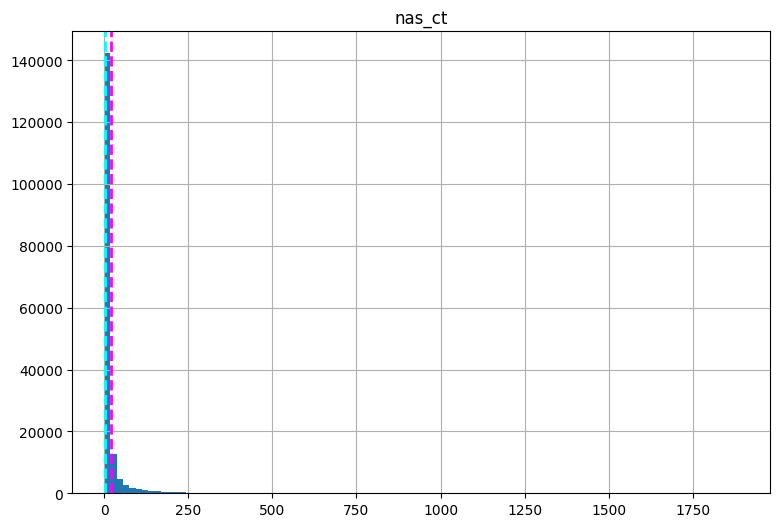

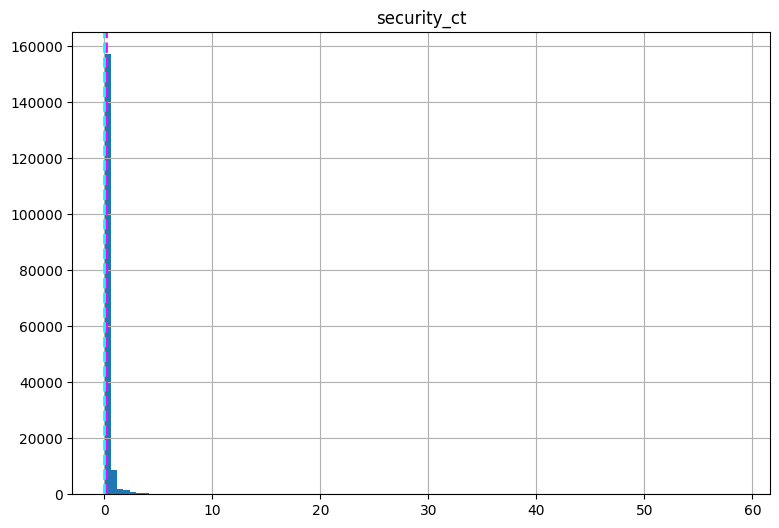

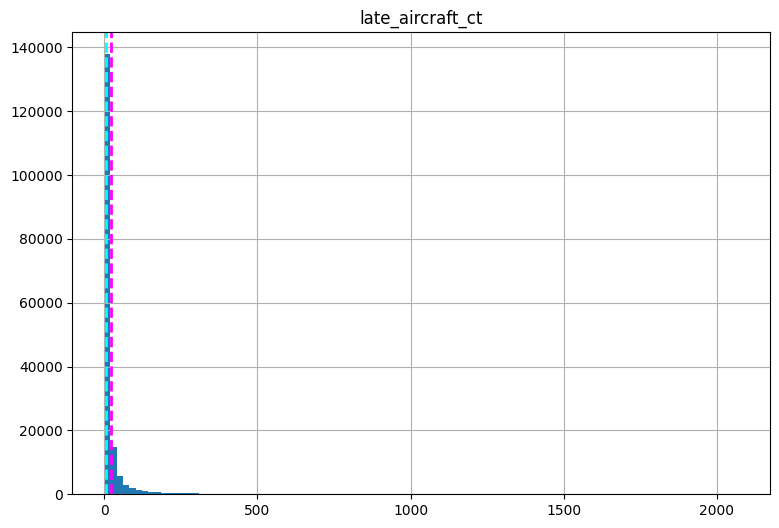

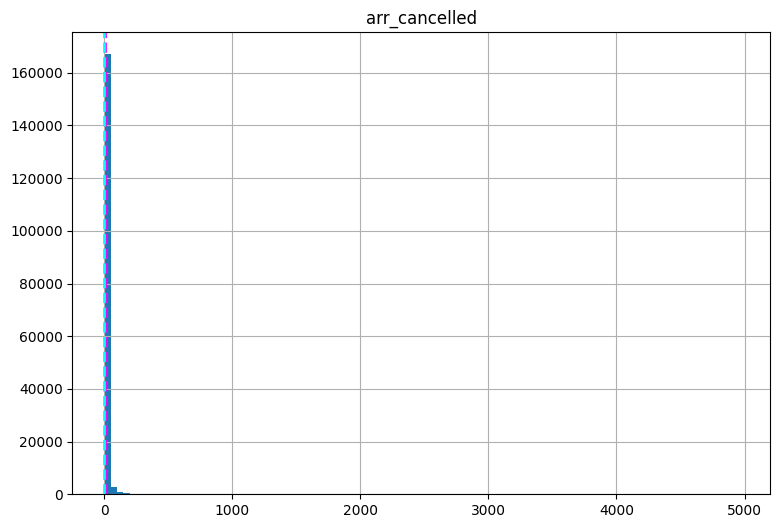

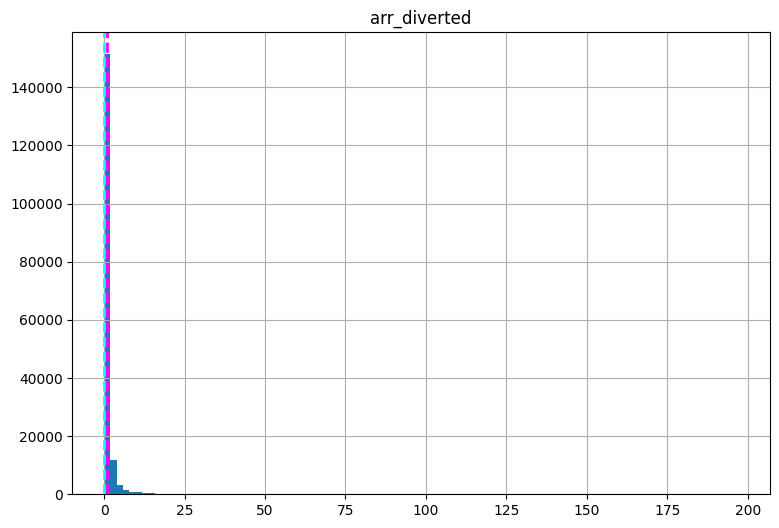

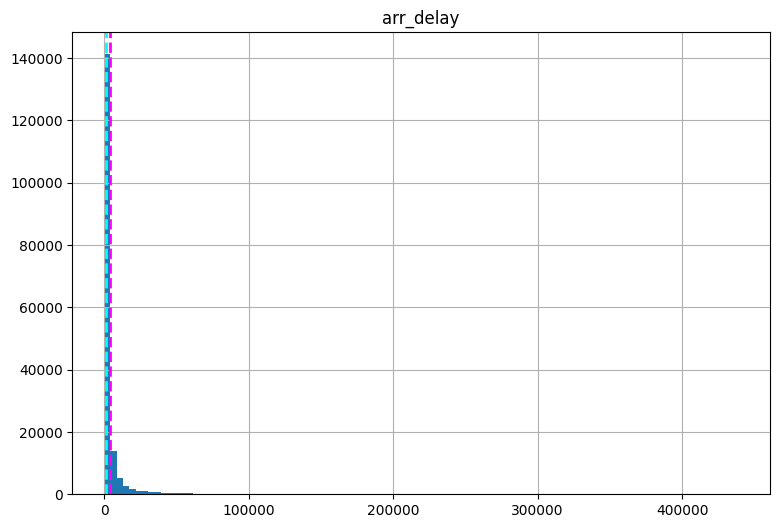

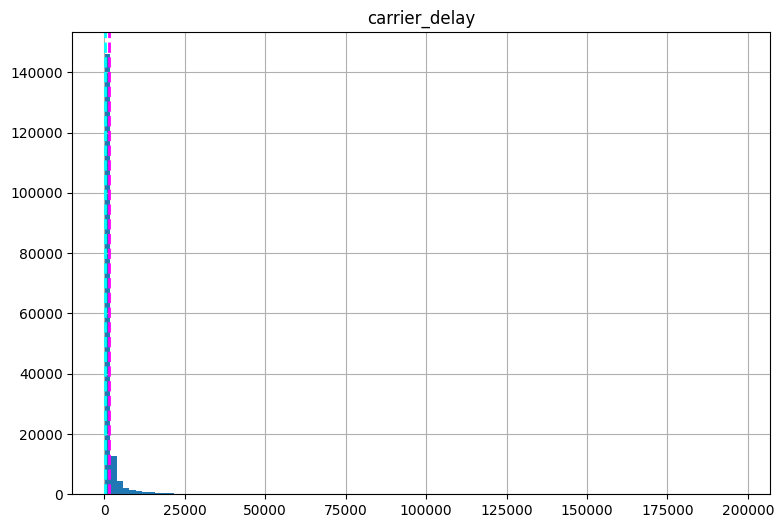

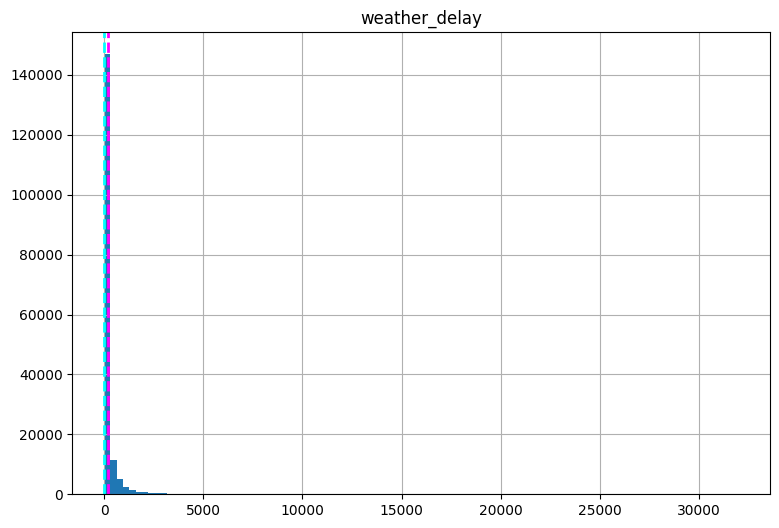

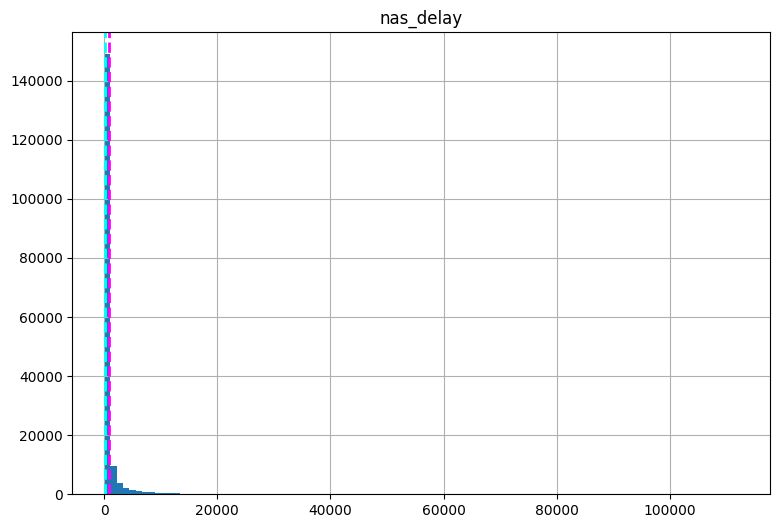

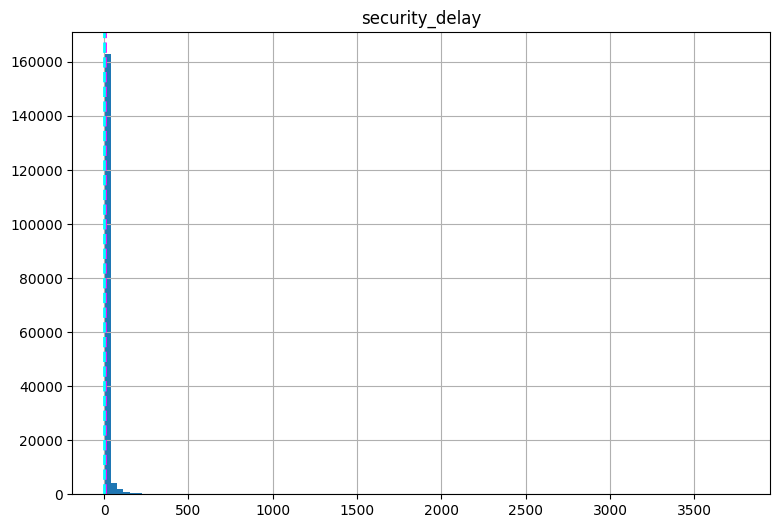

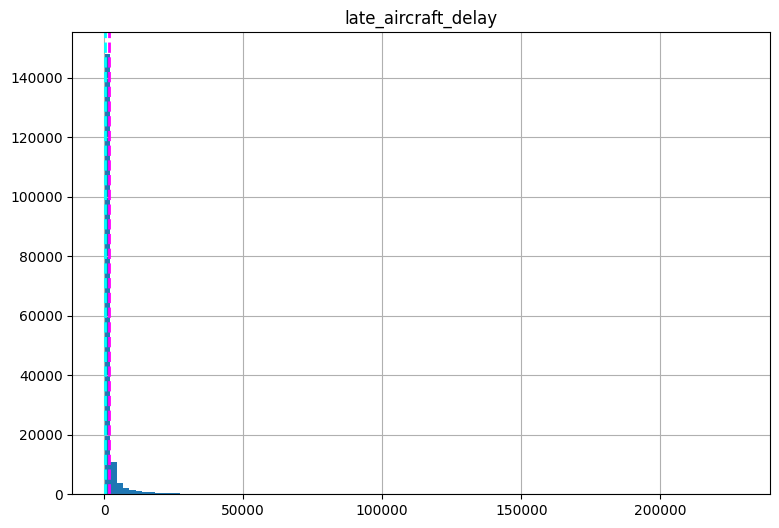

In [36]:
# Plot a histogram for each numerical column
# Remove date columns for now
numerical_feature = list(numerical_cols)
numerical_feature.remove('year')
numerical_feature.remove('month')

for col in numerical_feature:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

Categorical Columns

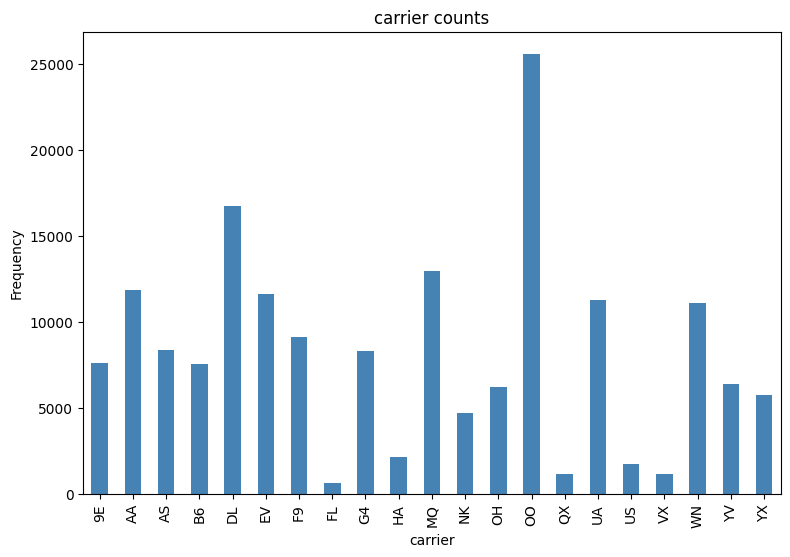

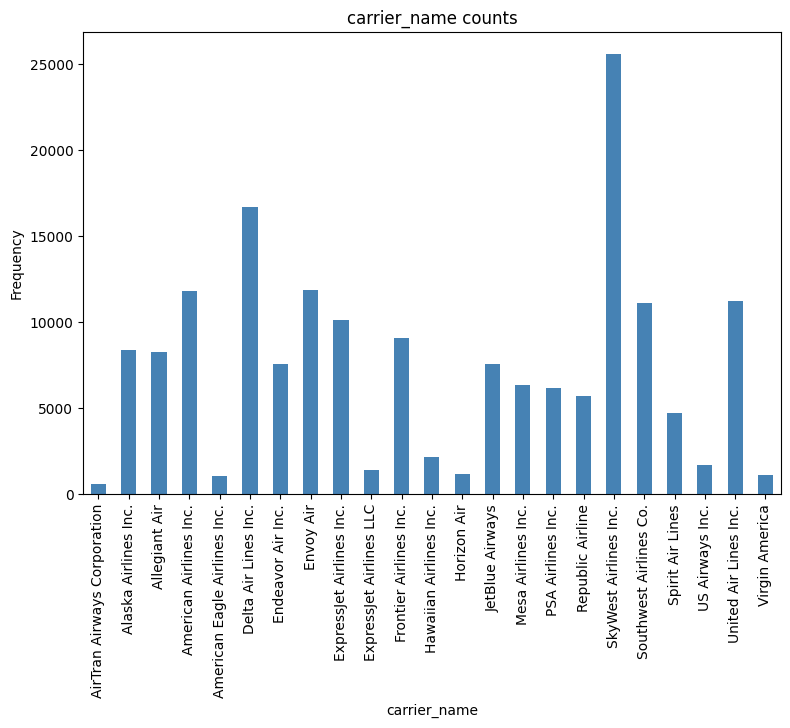

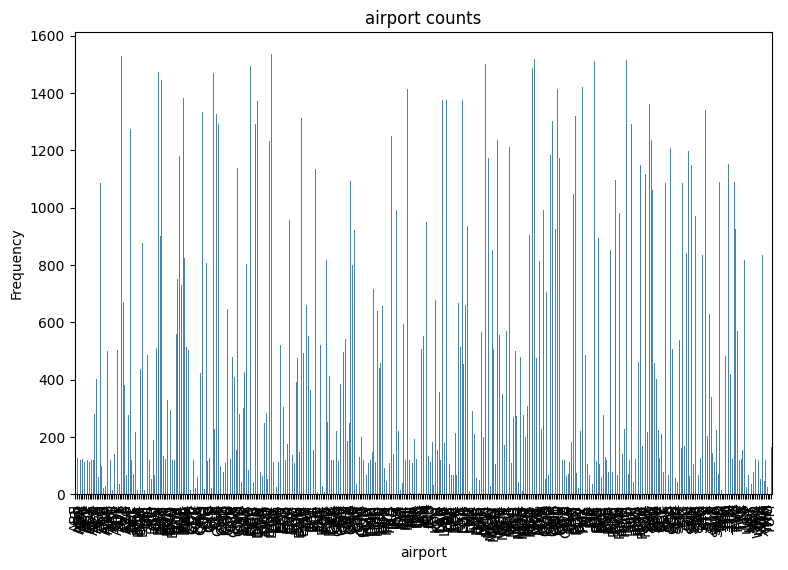

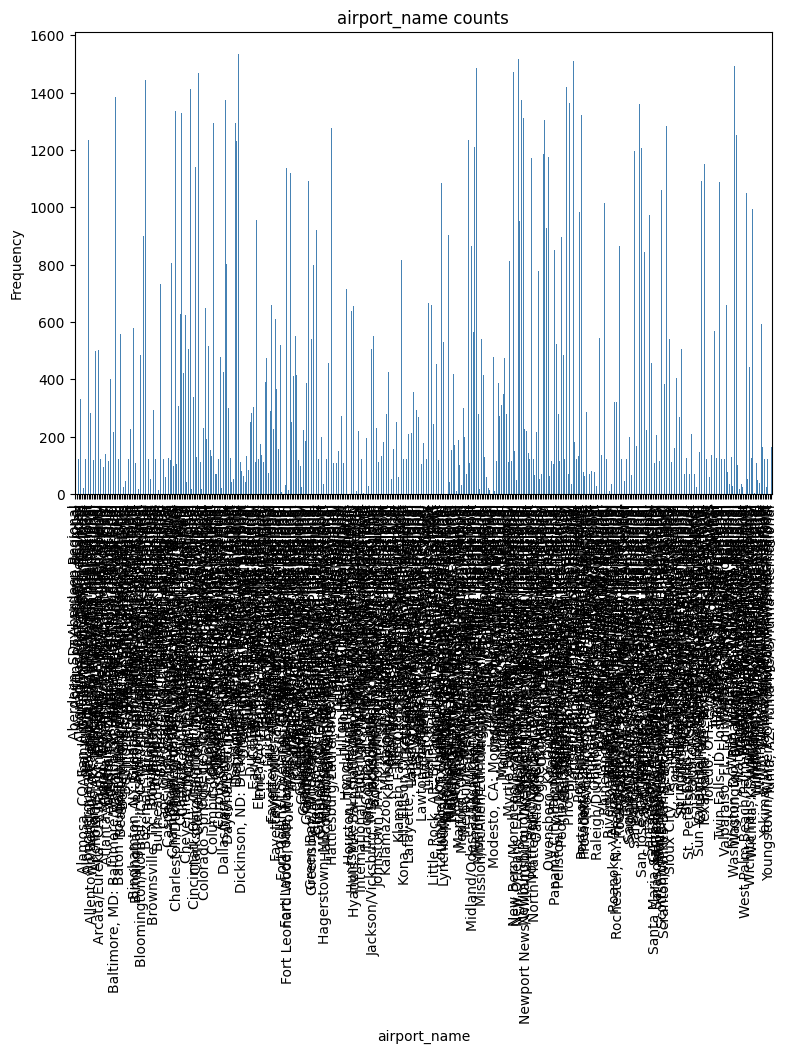

In [37]:
# plot a bar for each categorical feature count
for col in categorical_cols:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
plt.show()

### Relationships: Numerical & arr_delay

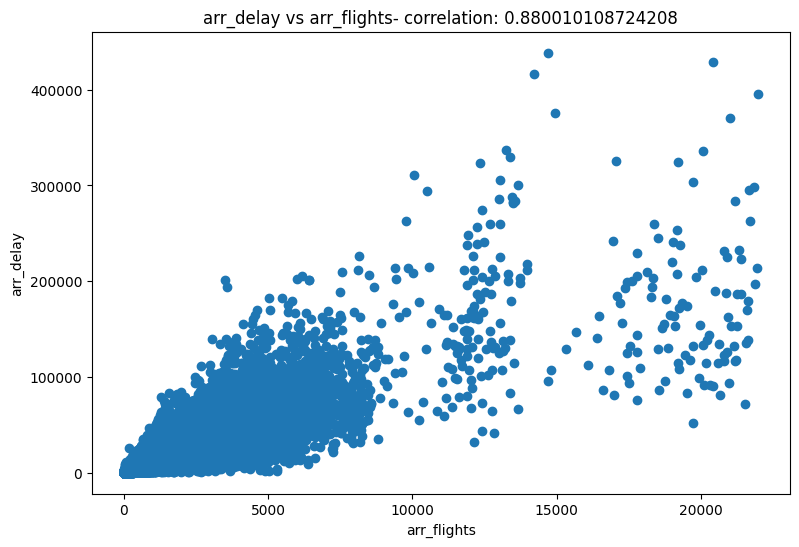

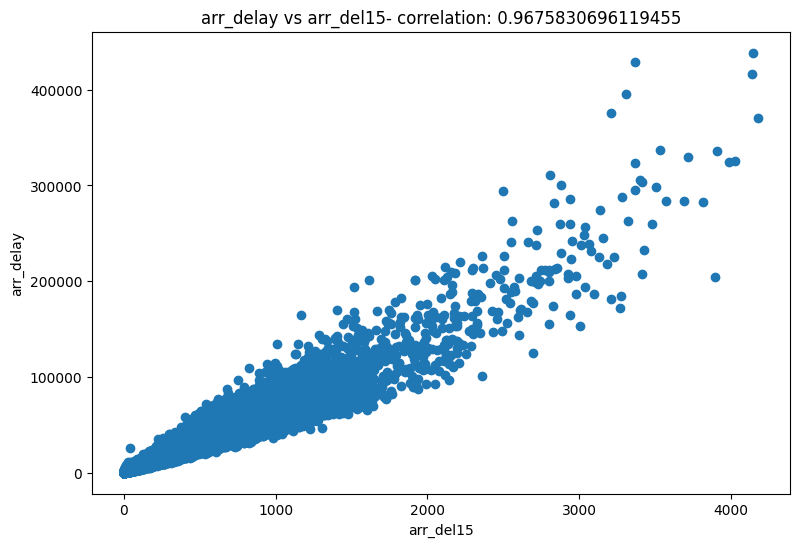

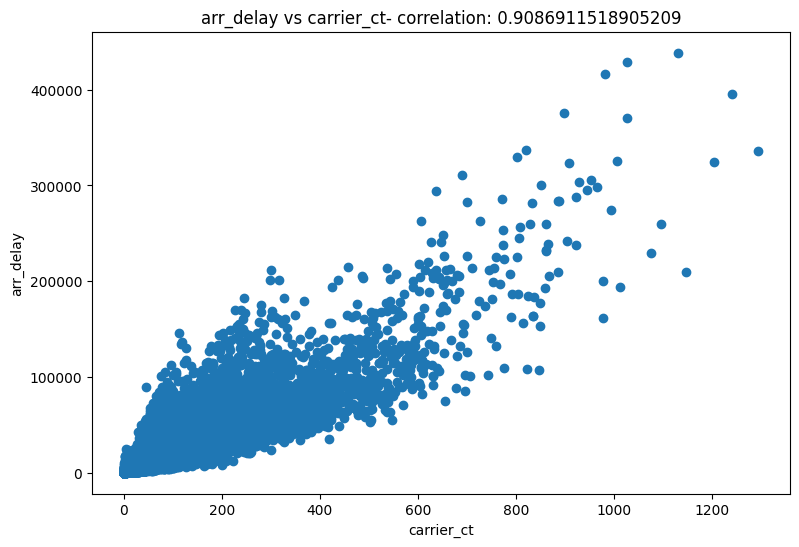

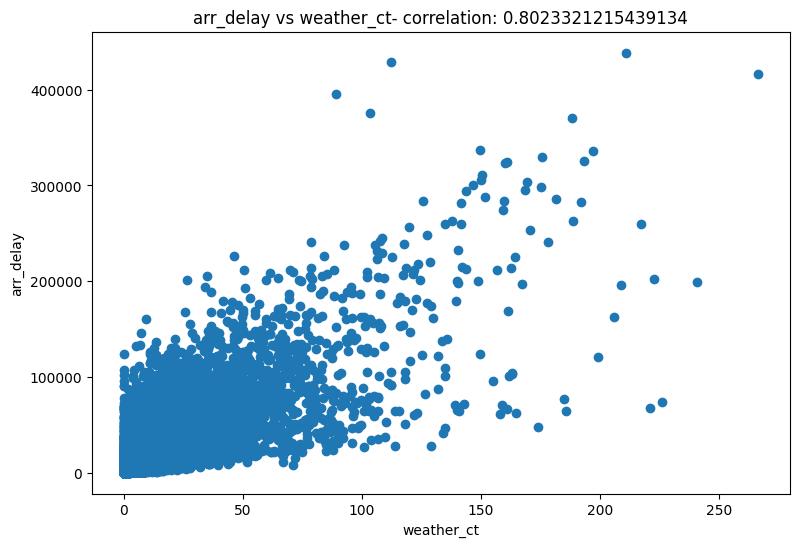

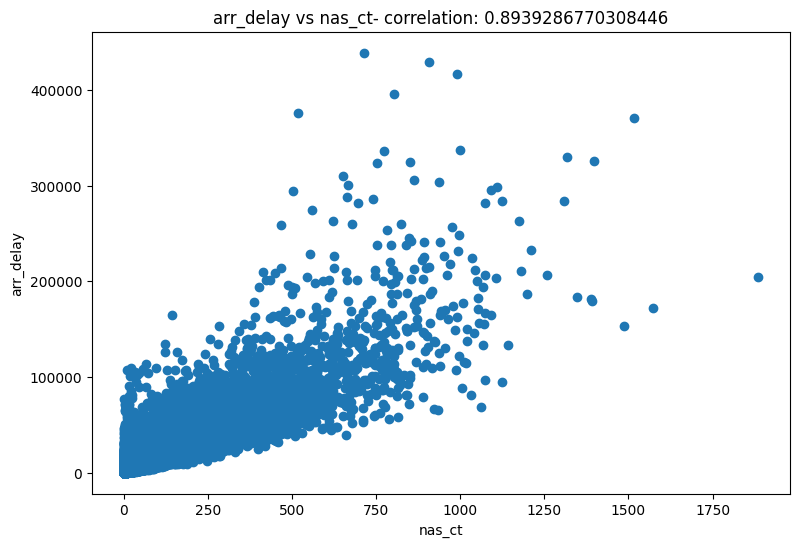

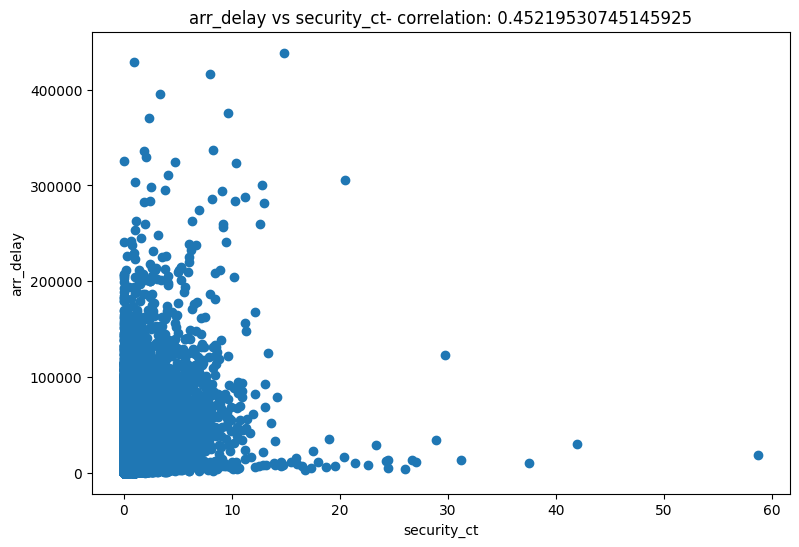

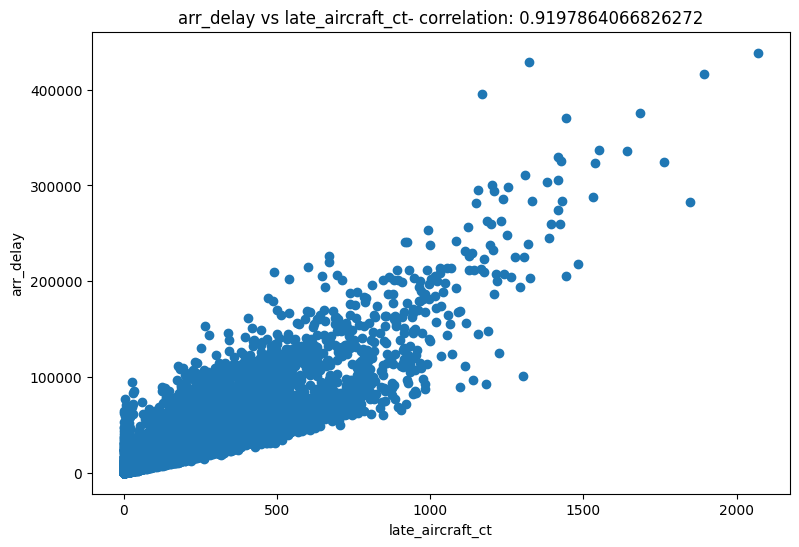

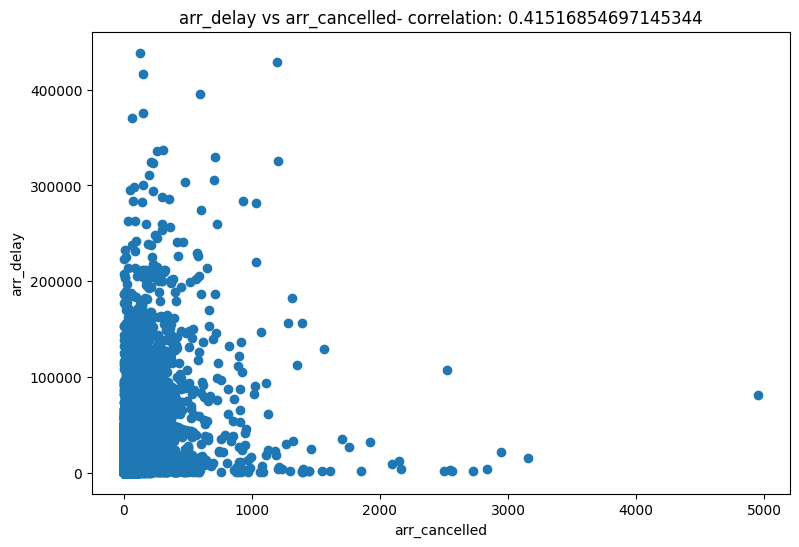

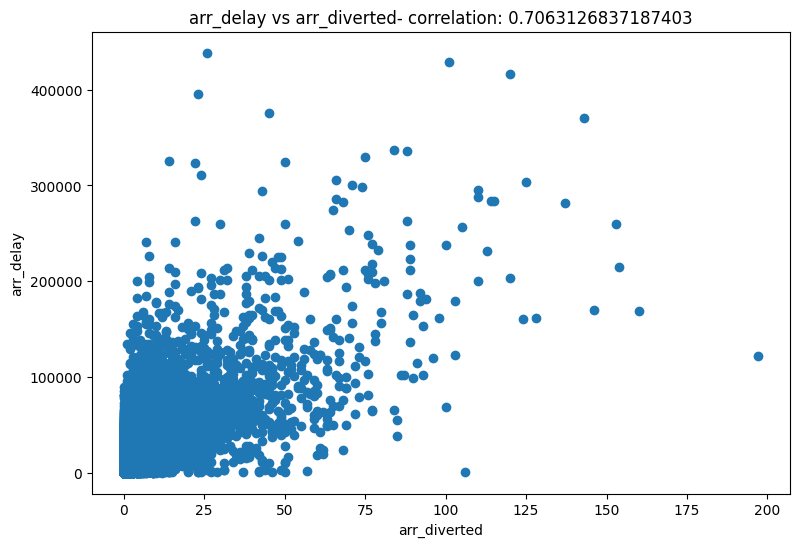

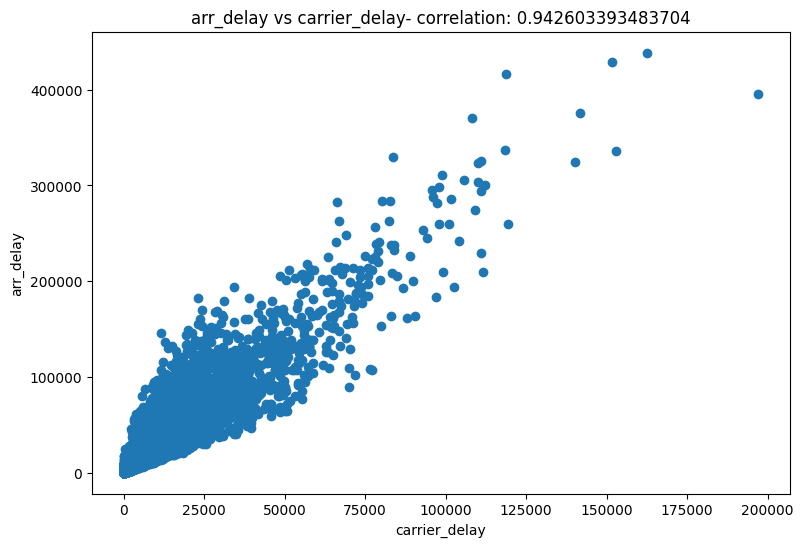

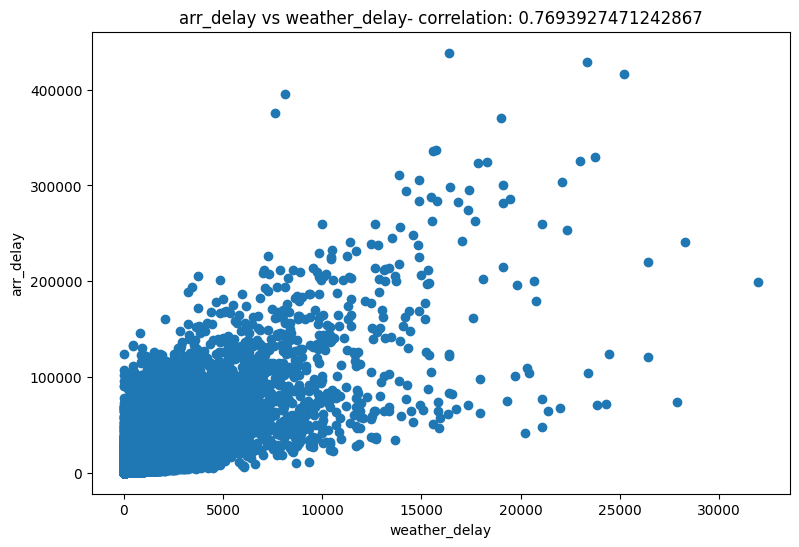

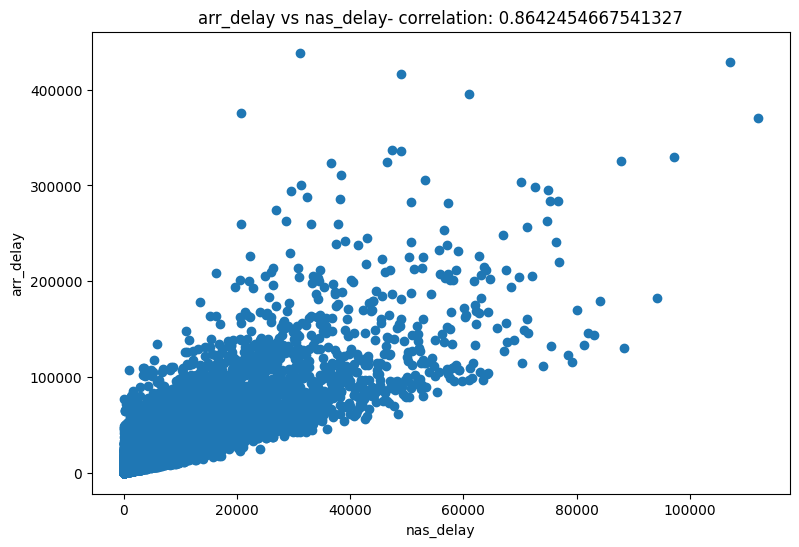

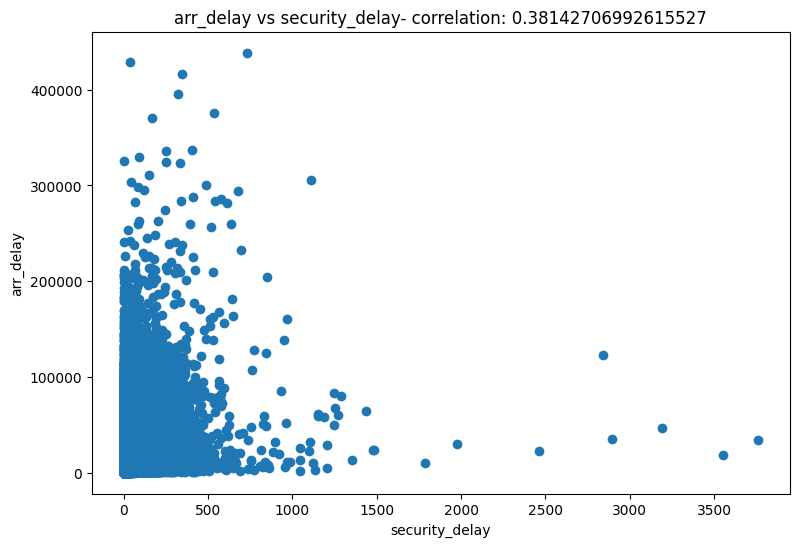

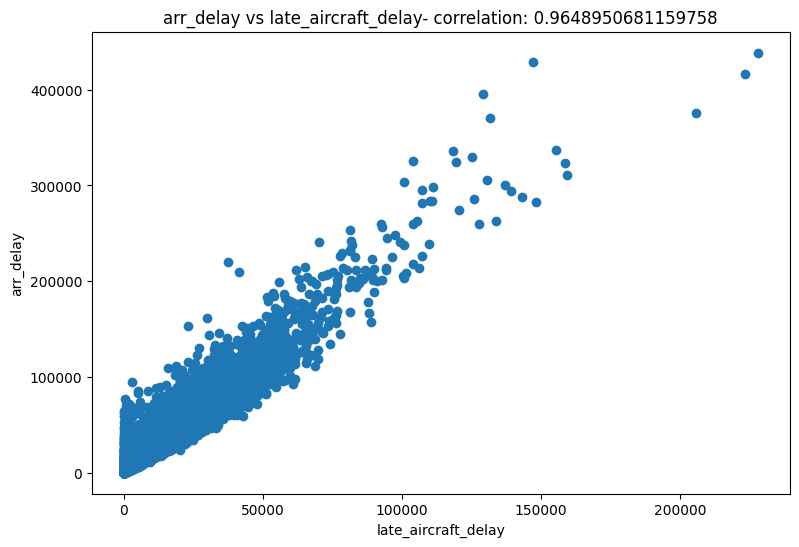

In [38]:
# Include the correlation coefficient
# Save the coef in a dataframe 'resultCorr'
resultCorr = []

# Plot scatter plots for each numerical column
# remove target columns
numerical_feature.remove('arr_delay')
for col in numerical_feature:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['arr_delay']
    correlation = feature.corr(label)

    # Our trasehold for a strong corr is 0.8
    if abs(correlation) >= 0.85:
      resultCorr.append([col, 'Correlated', correlation,'num'])
    else:
      resultCorr.append([col, 'No Correlated', correlation,'num'])

    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('arr_delay')
    ax.set_title('arr_delay vs ' + col + '- correlation: ' + str(correlation))
plt.show()

resultCorr = pd.DataFrame(resultCorr, columns=['Feature', 'Dependency', 'Correlation', 'Dtype'])

In [39]:
# review the strongest correlations
# Other columns will be ignored for training
resultCorr = resultCorr[resultCorr['Dependency'] == 'Correlated']
resultCorr

,Feature,Dependency,Correlation,Dtype
0,arr_flights,Correlated,0.880010,num
1,arr_del15,Correlated,0.967583,num
2,carrier_ct,Correlated,0.908691,num
4,nas_ct,Correlated,0.893929,num
6,late_aircraft_ct,Correlated,0.919786,num
9,carrier_delay,Correlated,0.942603,num
11,nas_delay,Correlated,0.864245,num
13,late_aircraft_delay,Correlated,0.964895,num


### Relationships: Categorical & arr_delay

In [40]:
# Set error alpha 0.05
alpha = 0.05
resultAnova = []

# Iterate categorical features
# Add year and month to the category cols list
categorical_cols.append('year')
categorical_cols.append('month')

for cat in categorical_cols:

    CategoryGroupList = df.groupby(cat)['arr_delay'].apply(list)

    F, pv = f_oneway(*CategoryGroupList)

#     check hypotesis using p value
    if pv < alpha:
        resultAnova.append([cat, 'Correlated', pv, 'cat'])
    else:
        resultAnova.append([cat, 'No Correlated', pv, 'cat'])

resultAnova = pd.DataFrame(resultAnova, columns=['Feature', 'Dependency', 'P-value', 'Dtype'])

In [41]:
# review the strongest correlations
# Other columns will be ignored for training
resultAnova = resultAnova[resultAnova['Dependency'] == 'Correlated']
resultAnova

,Feature,Dependency,P-value,Dtype
0,carrier,Correlated,0.000000e+00,cat
1,carrier_name,Correlated,0.000000e+00,cat
2,airport,Correlated,0.000000e+00,cat
3,airport_name,Correlated,0.000000e+00,cat
4,year,Correlated,3.408587e-309,cat
5,month,Correlated,1.661630e-179,cat


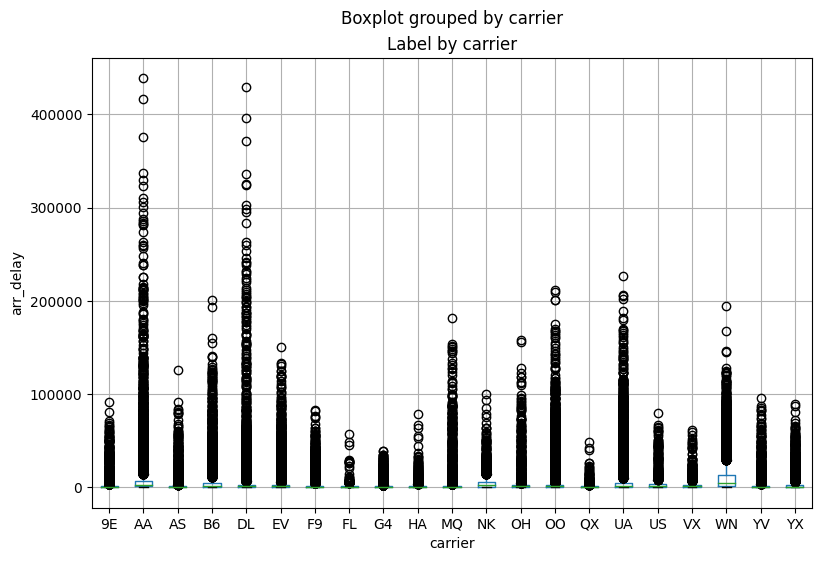

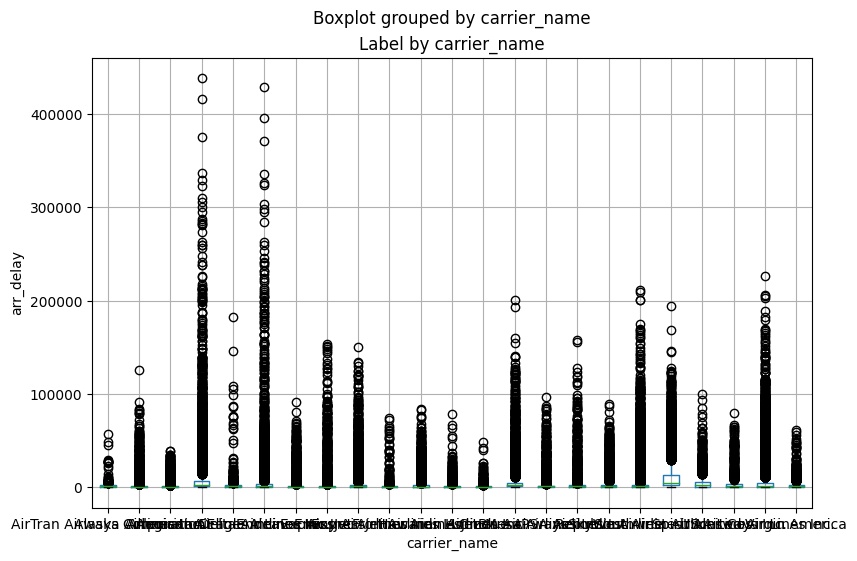

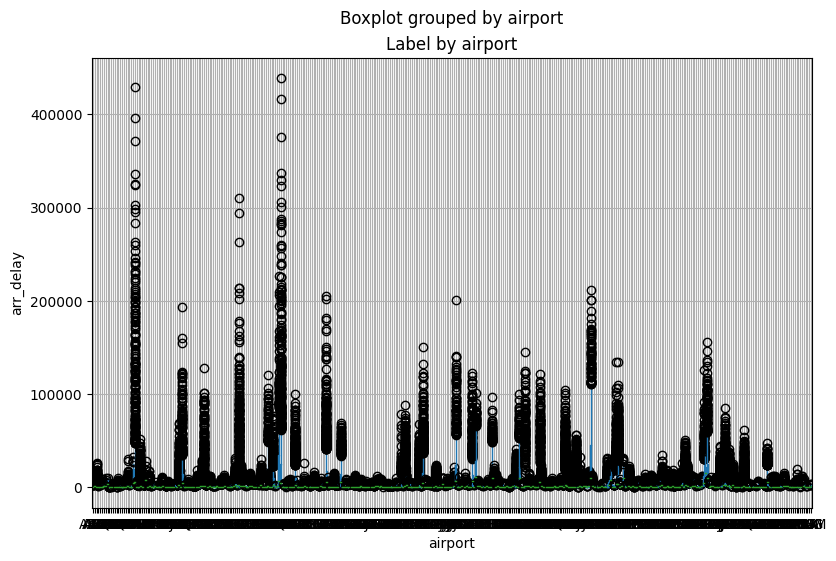

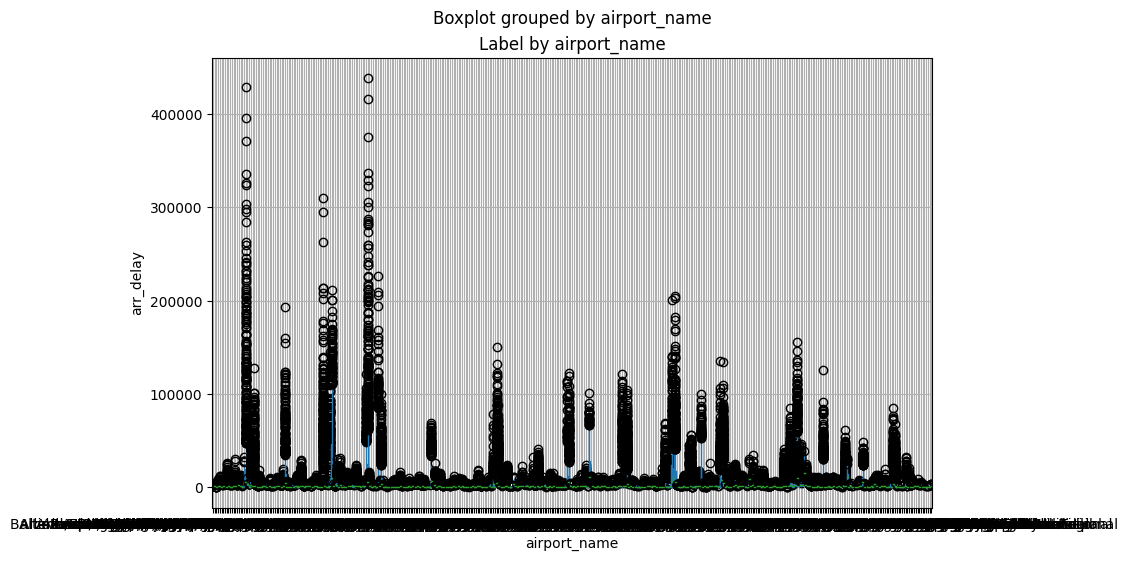

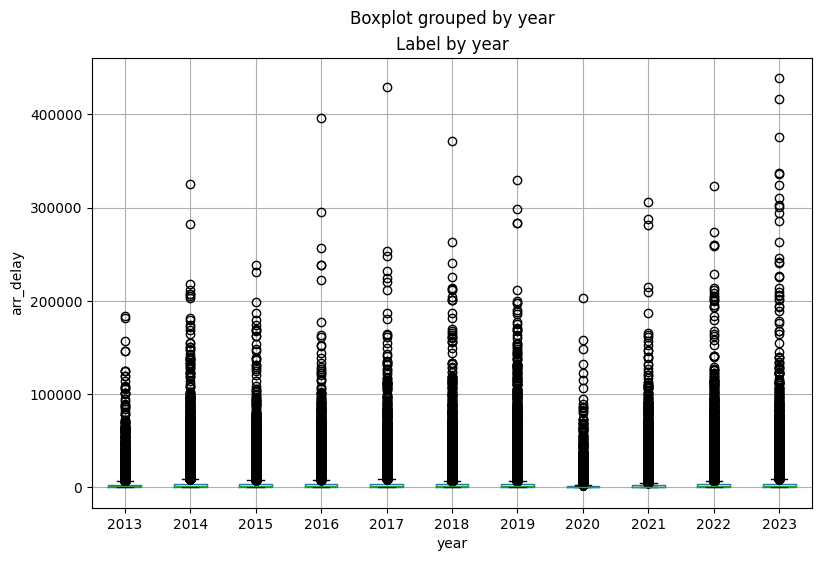

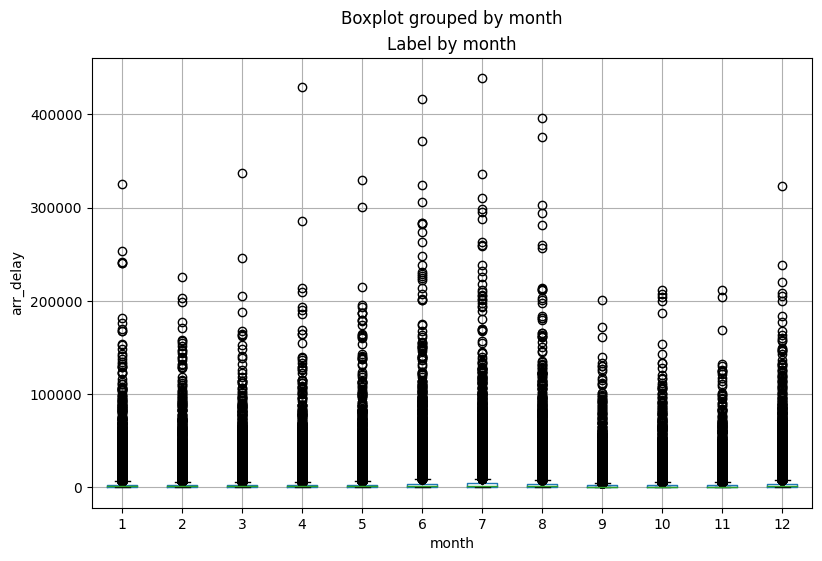

In [42]:
# Plot data to visualize the key influencers columns
for col in resultAnova['Feature']:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column='arr_delay',by=col,ax=ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("arr_delay")
plt.show()

## Train the Regression Model

The simpliest regression model is Lineal Regression.

We will use `LinearRegression` from `sklearn`. Steps on this section:

* Split Training and Validation Data
* Create Data Preprocess Pipeline
* Train the Model

### Split Training and Validation Data

In [43]:
final_cols = list(resultAnova['Feature']) + list(resultCorr['Feature'])

# Remove bias columns (arr_del15, carrier_delay, nas_delay, late_aircraft_delay, )
final_cols.remove('arr_del15')
final_cols.remove('carrier_delay')
final_cols.remove('nas_delay')
final_cols.remove('late_aircraft_delay')
final_cols

['carrier',
 'carrier_name',
 'airport',
 'airport_name',
 'year',
 'month',
 'arr_flights',
 'carrier_ct',
 'nas_ct',
 'late_aircraft_ct']

In [44]:
# Split training and validation data
# Separate target from predictions
X = df[final_cols]
y = df['arr_delay']

X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137332 entries, 170702 to 43567
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   carrier           137332 non-null  object 
 1   carrier_name      137332 non-null  object 
 2   airport           137332 non-null  object 
 3   airport_name      137332 non-null  object 
 4   year              137332 non-null  int64  
 5   month             137332 non-null  int64  
 6   arr_flights       137332 non-null  float64
 7   carrier_ct        137332 non-null  float64
 8   nas_ct            137332 non-null  float64
 9   late_aircraft_ct  137332 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 11.5+ MB


In [45]:
# Get numerical data and categorical columms from splitted data

numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['object']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

### Create Data Preprocess Pipeline

In [46]:
# Define preprocessing

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num', SimpleImputer(strategy='constant'),
                                 ['year', 'month', 'arr_flights', 'carrier_ct',
                                  'nas_ct', 'late_aircraft_ct']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['carrier', 'carrier_name', 'airport',
                                  'airport_name'])])

### Train the Model

In [47]:
# define the model

model = LinearRegression()
model

LinearRegression()

In [48]:
# Bundle preprocessor and model
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Preprocessing the training data, fit model
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['year', 'month',
                                                   'arr_flights', 'carrier_ct',
                                                   'nas_ct',
                                                   'late_aircraft_ct']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['carrier', 'carrier_name',
                                                   'airport',
                                                   'airport_name'])])),
                ('model', LinearRegression())])

# Evaluate the Model

In [49]:
# Make predictions using X_valid dataset

preds = my_pipeline.predict(X_valid)
preds

array([ 6709.87724124, -1849.12773229,  1410.98895323, ...,
        3976.79705252,  1365.11596587,   702.88511133])

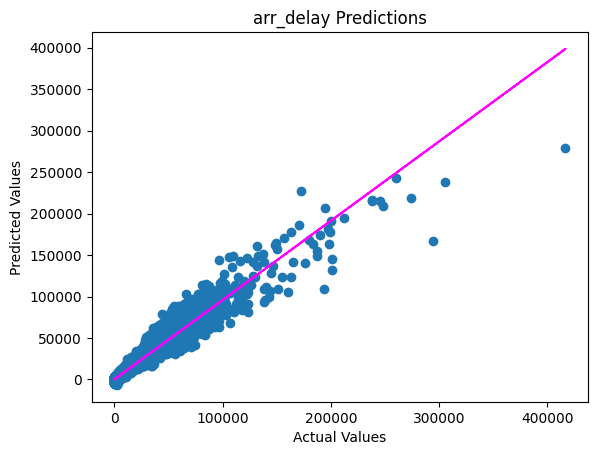

In [50]:
# Plot prediction vs target valid data
plt.scatter(y_valid, preds)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('arr_delay Predictions')
# overlay the regression line
z = np.polyfit(y_valid, preds, 1)
p = np.poly1d(z)
plt.plot(y_valid,p(y_valid), color='magenta')
plt.show()

In [51]:
# Calculate: Mean Square Error (MSE), Root Mean Square Error (RMSE) & R-squared

# Mean Square Error (MSE)
mse = mean_squared_error(y_valid, preds)
print("MSE:", mse)

# Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# R-squared
r2 = r2_score(y_valid, preds)
print("R2:", r2)

MSE: 9216916.31409278
RMSE: 3035.937468738903
R2: 0.9445703636320211


# Next Steps

* Fine Tunning Hyperparameters
* Try other models
* Save & Deploy Model